In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import export_graphviz
from graphviz import Source,Digraph
from sklearn.tree import DecisionTreeClassifier

ModuleNotFoundError: No module named 'graphviz'

In [10]:
array = np.arange(80)
data = pd.DataFrame(array)

In [11]:
data['stages'] = 0
data['X'] = 0

In [12]:
data.loc[0:20,'stages'] = data.loc[0:20,'stages'].apply(lambda x: [1,2,4])
data.loc[20:40,'stages']= data.loc[20:40,'stages'].apply(lambda x: [1,3,4])
data.loc[40:60,'stages']= data.loc[40:60,'stages'].apply(lambda x: [1,3,5,4])
data.loc[60:80,'stages']= data.loc[60:80,'stages'].apply(lambda x: [1,4])

data.loc[0:20,'X'] = data.loc[0:20,'X'].apply(lambda x:np.random.randint(-10,-1))
data.loc[20:40,'X'] = data.loc[20:40,'X'].apply(lambda x:np.random.randint(1,9))
data.loc[40:60,'X'] = data.loc[40:60,'X'].apply(lambda x:0)
data.loc[60:80,'X'] = data.loc[60:80,'X'].apply(lambda x:np.random.randint(10,20))

In [13]:
data = data.explode('stages')
data = data.rename(columns = {0:'id'})
data['from'] = data.groupby(['id'])['stages'].shift(1)

In [14]:
stages = pd.unique(data['stages'])
dot = Digraph(comment='Process',format = 'pdf')
for i in stages:
    dot.node(str(i))

In [15]:
b = []
edges = []
for i in range(1,len(data['stages'])):
    if data.iloc[i-1]['id'] == data.iloc[i]['id']:
        a = (data.iloc[i-1]['stages'],data.iloc[i]['stages'])
        if a not in b:        
            b.append(a)
for i in b:
    edges.append(str(i[0]) + str(i[1]))

In [16]:
dot.edges(edges)

In [17]:
list_id = []
for i in stages:
    transitions = list(filter(lambda x: '\t{} ->'.format(i) in x,dot.body))
    if len(transitions) > 1:
        print(transitions)
        list_nodes = list(map(lambda x: list(map(lambda s: int(s.strip()),x.strip().split("->"))),transitions))
    
        data_x_id = data.loc[data['stages'] == list_nodes[0][0],['id','X']]
        
        nodes = [node[1] for node in list_nodes]
        
        for param in nodes:
            mask_to = data['stages'] == param
            mask_from = data['from'] == list_nodes[0][0]
            mask = mask_to & mask_from
            list_id.append(data.loc[mask,['id']].values.reshape(-1))        
        
        for j in range(len(list_id)):
            data_x_id.loc[data_x_id['id'].isin(list_id[j]),'target'] = j    
        
        tree = DecisionTreeClassifier()    
        tree.fit(data_x_id['X'].values.reshape((-1,1)),data_x_id['target'])
        export_graphviz(tree, out_file='tree{}.dot'.format(i),
                feature_names=['X'],node_ids=True)

['\t1 -> 2', '\t1 -> 3', '\t1 -> 4']
['\t3 -> 4', '\t3 -> 5']


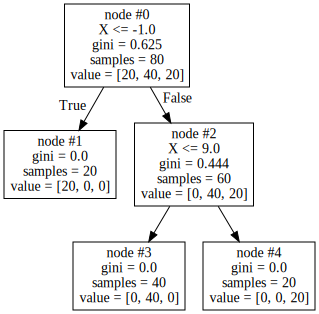

In [20]:
file = open('tree{}.dot'.format(1), 'r')
text=file.read()
Source(text)

In [31]:
dot.view()

'Digraph.gv.pdf'